# Modelo de Regresión Múltiple para los Determinantes del Ingreso

Pregunta
¿Cuáles son los determinantes del salario en los trabajadores mexicanos?

La informalidad laboral en México es un fenómeno vasto, persistente y multifacético que no puede comprenderse plenamente si se aborda únicamente desde un enfoque holístico que lo conciba como una gran unidad, total y homogénea. Si bien es importante reconocer su magnitud estructural, es mediante el análisis desagregado, es decir, el análisis sectorial, regional, educativo y ocupacional, que es posible identificar los factores específicos que generan, perpetúan y transforman la informalidad laboral.

Objetivo

Identificar el perfil sociodemográfico y laboral de los trabajadores informales en México.
Explicar las variaciones estructurales que relacionan el trabajo informal con la pobreza.

Metodología

Se utilizó la base de datos de la ENOE (3er trimestre de 2024) con enfoque en trabajadores ocupados con encuestas completas y en edad laboral (15 a 65 años). Se filtraron los datos para eliminar registros con ingresos negativos o extremos, y se aplicó el factor de expansión (fac_tri) para ponderar los resultados. La clasificación de empleos formales e informales se basó en la condición de la primera actividad (emp_ppal), con el fin de establecer los dos grupos de interés para su posterior comparación según características sociodemográficas (sexo, edad, escolaridad, ubicación geográfica) y condiciones laborales (tamaño de la unidad, tipo de ocupación).

Con el fin de identificar los factores que determinan el nivel de ingreso entre los trabajadores informales, se estimó un modelo de regresión lineal múltiple bajo los métodos de Mínimos Cuadrados Ordinarios (OLS) y Mínimos Cuadrados Ponderados (WLS), utilizando el factor de expansión (fac_tri) como ponderador. Este análisis busca cuantificar en qué medida las características sociodemográficas y laborales influyen en la variación del ingreso dentro del sector informal.

El modelo se especificó de la siguiente forma:

ln(ingreso)=𝛽0 + 𝛽1(edad) + 𝛽2(sexo) + 𝛽3(nivel educativo) + 𝛽4(tamaño de la unidad económica) + 𝛽5(tipo de ocupación) + 𝛽6(ámbito urbano/rural) + 𝛽7(entidad federativa)

Se aplicaron las pruebas de normalidad (Shapiro-Wilk, Anderson-Darling y Jarque-Bera) para verificar los supuestos clásicos del modelo; multicolinealidad (VIF) para asegurar independencia entre los predictores; y heterocedasticidad (Breusch-Pagan y White) para evaluar la constancia de la varianza de los errores. Ante la evidencia de heterocedasticidad, se implementó la corrección de White, y posteriormente se reestimó el modelo mediante WLS para obtener estimadores eficientes y robustos.

Con el propósito de evaluar la estabilidad y capacidad predictiva de los modelos de regresión, se aplicó una validación cruzada K-Fold con tres particiones (K=3), manteniendo una semilla aleatoria de 42 para garantizar la reproducibilidad de los resultados. La métrica utilizada para medir el ajuste predictivo fue el coeficiente de determinación promedio (R²), que cuantifica la proporción de la varianza del ingreso explicada por las variables independientes en distintos subconjuntos de datos.

Además del modelo de regresión lineal ponderado, se implementaron dos algoritmos de aprendizaje supervisado para validar la robustez de los determinantes del ingreso: Random Forest Regressor y Gradient Boosting Regressor. Los tres modelos fueron evaluados mediante validación cruzada K-Fold (K=5) y utilizando el coeficiente de determinación (R²) como métrica principal, con el fin de medir la estabilidad del ajuste y la capacidad predictiva fuera de la muestra.

In [2]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
df = pd.read_stata(r"C:\Users\ASTRID\Downloads\enoe_2024_trim3_dta\ENOE_SDEMT324.dta", convert_categoricals=False)

In [ ]:
#Transformación de variables
df['ent'] = df['ent'].astype('category')
df['ent'] = df['ent'].cat.reorder_categories(sorted(df['ent'].unique()))
df['sex_bin'] = df['sex'].map({1: 0, 2: 1})   # 0 = hombre, 1 = mujer
df['ur_bin'] = df['ur'].map({1: 0, 2: 1})     # 0 = urbano, 1 = rural

In [5]:
# Análisis por estado
# 1. Crear variables dummy para cada estados
dummies_ent = pd.get_dummies(df['ent'], prefix='ent')
# 2. Quitar a la cdmx para evitar repeticion
dummies_ent = dummies_ent.drop('ent_9.0', axis=1) # CDMX como base
dummies_ent = dummies_ent.astype(int)
# 3. Incluir la nueva columna en el df original
df = pd.concat([df, dummies_ent], axis=1)

In [6]:
import numpy as np
import pandas as pd

def log_ingreso(df, columna='ingocup', nueva_col='log_ingocup'):
    """
    Convierte la columna de ingreso a su logaritmo natural.
    Crea una nueva columna en el DataFrame.
    
    Parámetros:
    df : pd.DataFrame
        DataFrame con los datos originales.
    columna : str
        Nombre de la columna de ingreso a transformar.
    nueva_col : str
        Nombre de la nueva columna con logaritmo.
    
    Retorna:
    pd.DataFrame
        DataFrame con la nueva columna logaritmada.
    """
    # Evitar problemas con ceros o negativos
    if (df[columna] <= 0).any():
        print("Advertencia: se reemplazarán valores <= 0 por NaN antes de logaritmo.")
        df[nueva_col] = df[columna].replace({0: np.nan}).apply(lambda x: np.log(x) if x > 0 else np.nan)
    else:
        df[nueva_col] = np.log(df[columna])
    
    return df
df = log_ingreso(df, columna='ingocup', nueva_col='log_ingocup')

Advertencia: se reemplazarán valores <= 0 por NaN antes de logaritmo.


In [7]:
df_informal = df[
    (df['r_def'] == 0) &   # Solo encuestas completas (00 es igual a 0 en int)
    (df['clase2'] == 1) &  # Solo ocupados
    (df['eda'] >= 15) &    # Edad mínima 15 años, primero fue de 18, pero por los datos obtenidos posteriormente, vi necesario bajar la edad mínima
    (df['eda'] <= 65) &    # Edad máxima 65 años
    (df['log_ingocup'] != 0) & # Ingresos distintos de cero
    (df['emp_ppal'] == 1)   # Solo los que tienen empleo informal
]
filas, columnas = df_informal.shape #las columnas son las variables y las filas las observaciones (viviendas)
print(f'Tamano de la base de datos: {filas} filas y {columnas} columnas')
print('Primeras filas del dataframe:\n ', df_informal.head())

Tamano de la base de datos: 91575 filas y 148 columnas
Primeras filas del dataframe:
      r_def  loc   mun   est  est_d_tri  est_d_men  ageb  t_loc_tri  t_loc_men  \
2     0.0  NaN   6.0  30.0      124.0        NaN   0.0        1.0        NaN   
3     0.0  NaN   6.0  30.0      124.0        NaN   0.0        1.0        NaN   
15    0.0  NaN   7.0  30.0      676.0      637.0   0.0        1.0        1.0   
20    0.0  NaN  11.0  30.0      676.0      637.0   0.0        1.0        1.0   
21    0.0  NaN  12.0  30.0      676.0      637.0   0.0        1.0        1.0   

    cd_a  ... ent_24.0  ent_25.0  ent_26.0  ent_27.0  ent_28.0  ent_29.0  \
2    1.0  ...        0         0         0         0         0         0   
3    1.0  ...        0         0         0         0         0         0   
15   1.0  ...        0         0         0         0         0         0   
20   1.0  ...        0         0         0         0         0         0   
21   1.0  ...        0         0         0         0

In [8]:
print(df_informal[['eda', 'log_ingocup', 'emp_ppal']].describe())

                eda   log_ingocup  emp_ppal
count  91575.000000  63553.000000   91575.0
mean      38.558984      8.660229       1.0
std       13.862604      0.790321       0.0
min       15.000000      2.639057       1.0
25%       26.000000      8.294050       1.0
50%       38.000000      8.771835       1.0
75%       50.000000      9.108308       1.0
max       65.000000     11.949889       1.0


In [9]:
df_formal = df[
    (df['r_def'] == 0) &   # Solo encuestas completas (00 es igual a 0 en int)
    (df['clase2'] == 1) &  # Solo ocupados
    (df['eda'] >= 15) &    # Edad mínima 15 años
    (df['eda'] <= 65) &    # Edad máxima 65 años
    (df['ingocup'] != 0) & # Ingresos distintos de cero
    (df['emp_ppal'] == 2)   # Solo los que tienen seguridad social
]
filas, columnas = df_formal.shape #las columnas son las variables y las filas las observaciones (viviendas)
print(f'Tamano de la base de datos: {filas} filas y {columnas} columnas')
print('Primeras filas del dataframe:\n ', df_formal.head())

Tamano de la base de datos: 61223 filas y 148 columnas
Primeras filas del dataframe:
      r_def  loc   mun   est  est_d_tri  est_d_men  ageb  t_loc_tri  t_loc_men  \
1     0.0  NaN  10.0  30.0      124.0        NaN   0.0        1.0        NaN   
25    0.0  NaN  13.0  30.0      676.0      637.0   0.0        1.0        1.0   
34    0.0  NaN  11.0  20.0      123.0        NaN   0.0        1.0        NaN   
35    0.0  NaN  17.0  30.0      676.0      637.0   0.0        1.0        1.0   
36    0.0  NaN  17.0  30.0      676.0      637.0   0.0        1.0        1.0   

    cd_a  ... ent_24.0  ent_25.0  ent_26.0  ent_27.0  ent_28.0  ent_29.0  \
1    1.0  ...        0         0         0         0         0         0   
25   1.0  ...        0         0         0         0         0         0   
34   1.0  ...        0         0         0         0         0         0   
35   1.0  ...        0         0         0         0         0         0   
36   1.0  ...        0         0         0         0

In [10]:
print(df_formal[['eda', 'log_ingocup', 'emp_ppal']].describe())

                eda   log_ingocup  emp_ppal
count  61223.000000  61223.000000   61223.0
mean      38.717018      9.335873       2.0
std       11.711624      0.528958       0.0
min       15.000000      4.605170       2.0
25%       29.000000      8.987197       2.0
50%       38.000000      9.282661       2.0
75%       48.000000      9.619133       2.0
max       65.000000     12.301383       2.0


In [11]:
#funcion para eliminar outliers (datos extremos) usando el rango intercuartil (IQR)
def eliminar_outliers(df_informal, columna):
    Q1 = df_informal[columna].quantile(0.25)
    Q3 = df_informal[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR #normalmebte no es 1.5, sino a partir de 3
    return df_informal[(df_informal[columna] >= limite_inf)&(df_informal[columna]<= limite_sup)]
df_informal= eliminar_outliers(df_informal, 'log_ingocup') #salario

In [12]:
#funcion para eliminar outliers (datos extremos) usando el rango intercuartil (IQR)
def eliminar_outliers(df_formal, columna):
    Q1 = df_formal[columna].quantile(0.25)
    Q3 = df_formal[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR #normalmebte no es 1.5, sino a partir de 3
    return df_formal[(df_formal[columna] >= limite_inf)&(df_formal[columna]<= limite_sup)]
df_formal= eliminar_outliers(df_formal, 'log_ingocup') #salario

In [13]:
""""esta función permitirá clasificar los niveles educativos entre las categorías del análisis: 
1. Educación básica (preescolar, primaria y secundaria)
2. Educación media superior (preparatoria, normal, escuela técnica)
2. Educación superior (universidad)
3. Educación de especialidad (maestría y doctorado)
"""
def clasificar_educacion(valor):
    if valor == 0:
        return 'Sin estudios'
    elif valor in [1, 2, 3]:
        return 'Básica'
    elif valor in [4, 5, 6]:
        return 'Media Superior'
    elif valor == 7:
        return 'Superior'
    elif valor in [8,9]:
        return'Especialidad'
    else:
        return 'No especificado'

df_informal.loc[:,'nivel_educativo'] = df_informal['cs_p13_1'].apply(clasificar_educacion).copy()

df_formal.loc[:,'nivel_educativo'] = df_formal['cs_p13_1'].apply(clasificar_educacion).copy()

In [14]:
# Para df_formal
df_formal = df_formal[df_formal['nivel_educativo'] != 'No especificado']

# Para df_informal
df_informal = df_informal[df_informal['nivel_educativo'] != 'No especificado']

In [15]:
#función para catalogar el tamaño de las unidades económicas
def clasificar_ambito(valor):
    if valor in [2, 3]:
        return 'Micronegocio (sin/con establecimiento)'
    elif valor == 4:
        return 'Pequeño'
    elif valor in [5, 6]:
        return 'Mediano/Grande'
    elif valor == 7:
        return 'Gobierno'
    else:
        return 'Otro'

df_informal.loc[:,'tam_unidad'] = df_informal['ambito2'].apply(clasificar_ambito).copy()
df_formal.loc[:,'tam_unidad'] = df_formal['ambito2'].apply(clasificar_ambito).copy()

In [16]:
#función para catalogar el tipo de ocupación
def clasificar_ocupacion(valor):
    if valor == 1:
        return 'Trabajadores subordinados y remunerados'
    elif valor == 2:
        return 'Empleadores'
    elif valor == 3:
        return 'Trabajadores por cuenta propia'
    elif valor == 4:
        return 'Trabajadores sin pago'
    elif valor == 5:
        return 'No especificado'
    else:
        return None

df_informal.loc[:,'tipo_ocup'] = df_informal['pos_ocu'].apply(clasificar_ocupacion).copy()
df_formal.loc[:,'tipo_ocup'] = df_formal['pos_ocu'].apply(clasificar_ocupacion).copy()

In [25]:
categoricas2 = ['nivel_educativo', 'tam_unidad', 'tipo_ocup', 'ur', 'sex']

#porque hay heterocedasticidad: por la cantidad de datos y por ejemplo, en educacion, los que tienen doctorado estan tanto el egresado como el profesor con 20 años dando clase

In [65]:
# Descripción estadística
num_vars = ['eda', 'log_ingocup', 'ur_bin', 'sex_bin']
desc_formal = df_formal[num_vars].describe().T
desc_informal = df_informal[num_vars].describe().T
# Colocamos el discriminante (informalidad)
desc_formal['sector'] = 'Formal'
desc_informal['sector'] = 'Informal'
#Creación de la tabla
tabla_numericas = pd.concat([desc_formal, desc_informal])
tabla_numericas = tabla_numericas[['sector', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
tabla_numericas #el formato queda mejor asi solo que con print

,sector,mean,std,min,25%,50%,75%,max
eda,Formal,38.585886,11.690565,15.000000,29.000000,38.000000,48.000000,65.000000
log_ingocup,Formal,9.322789,0.436334,8.058327,9.008224,9.282661,9.615805,10.566176
ur_bin,Formal,0.272023,0.445006,0.000000,0.000000,0.000000,1.000000,1.000000
sex_bin,Formal,0.412812,0.492344,0.000000,0.000000,0.000000,1.000000,1.000000
eda,Informal,38.423450,13.733514,15.000000,26.000000,38.000000,50.000000,65.000000
log_ingocup,Informal,8.735324,0.635330,7.073270,8.366370,8.771835,9.108308,10.325482
ur_bin,Informal,0.455893,0.498055,0.000000,0.000000,0.000000,1.000000,1.000000
sex_bin,Informal,0.426312,0.494544,0.000000,0.000000,0.000000,1.000000,1.000000


In [ ]:
np.exp(8.73) #para interpretar el valor del logaritmo, hay que convertirlo

np.float64(6185.728111201582)

In [70]:
#Formato de vista individual
cat_vars = ['nivel_educativo', 'tam_unidad', 'tipo_ocup', 'sex_bin', 'ur_bin']
tablas_cat = {}
for var in cat_vars:
    formal_counts = df_formal[var].value_counts(normalize=True) * 100
    informal_counts = df_informal[var].value_counts(normalize=True) * 100
    tablas_cat[var] = pd.concat([formal_counts, informal_counts], axis=1, keys=['Formal', 'Informal']).fillna(0)

tablas_cat['tipo_ocup']   #este valor puede ser cambiado para mostrar cualquier tabla, con su respectivo porcentaje entre sectores

,Formal,Informal
tipo_ocup,,
Trabajadores subordinados y remunerados,91.594933,65.192575
Trabajadores por cuenta propia,4.757234,29.769704
Empleadores,3.647833,5.037721


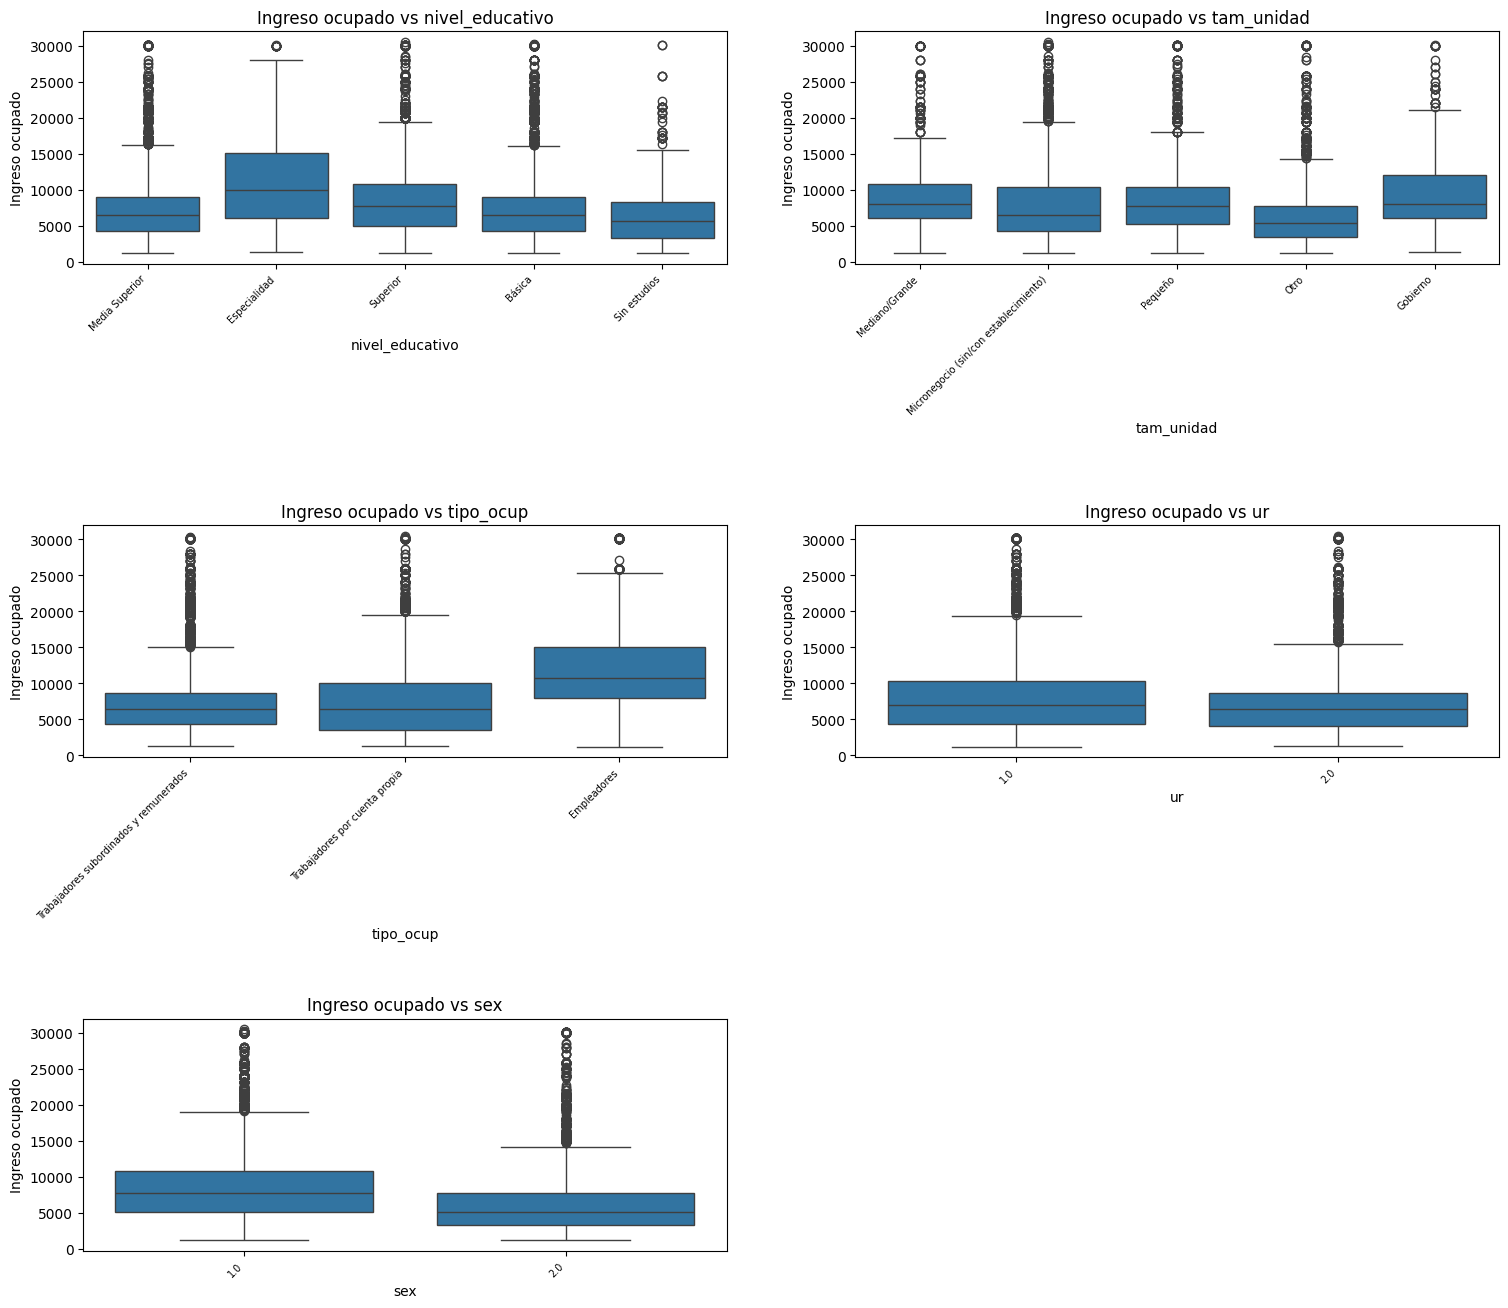

In [81]:
# Crear gráfico
plt.figure(figsize=(16, 14))

for i, var in enumerate(categoricas2):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(x=var, y='ingocup', data=df_informal)  
    plt.title(f'Ingreso ocupado vs {var}')
    plt.xlabel(var)
    plt.ylabel('Ingreso ocupado')
    plt.xticks(rotation=45, ha='right', fontsize=7) 

plt.tight_layout(pad=4.0)
plt.show()

Se observa que los trabajadores formales presentan un ingreso logaritmo promedio de 9.32, equivalente a aproximadamente 11 200 pesos mensuales, mientras que los trabajadores informales registran un promedio de 8.74, es decir, cerca de 6 200 pesos mensuales. Esta diferencia representa una brecha salarial de alrededor de 80%. La disparidad en el nivel educativo de los trabajadores es significante para determinar su probabilidad de tener un trabajo formal o informal. Observamos que la mayor parte de los trabajadores formales tienen estudios de preparatoria o de universidad (64.51%), mientras que en el sector informal casi la misma proporción tiene estudios solo de educación básica (57.48%). Además, se puede apreciar que el tamaño de la unidad donde se labora también tiene sus implicaciones en la condición del trabajador: mientras el empleo formal se concentra en medianas y grandes empresas, el empleo informal está concentrado en los micronegocios. En cuanto al tipo de ocupación, en ambos casos la mayor proporción se concentra en los trabajadores subordinados y remunerados; sin embargo, mientras que el empleo formal se encuentra fuertemente concentrado en este grupo (91.59 %), el sector informal muestra una estructura más heterogénea, con una presencia importante de trabajadores por cuenta propia (29.76 %) y, en menor medida, de empleadores (5.03 %). Este patrón refleja la diversidad de arreglos laborales en la informalidad y su menor dependencia de las relaciones laborales tradicionales.

### Modelo de Regresión Múltiple para Determinantes del Salaro en Trabajadores Informales

In [18]:
# Variables base 
X = df_informal[['eda', 'sex_bin', 'nivel_educativo', 'tam_unidad', 'tipo_ocup', 'ur_bin']]
y = df_informal['log_ingocup']

# Convertir las demás categóricas a dummies
X = pd.get_dummies(X, columns=['nivel_educativo', 'tam_unidad', 'tipo_ocup'], drop_first=True)

# Unir tus dummies de los estados
X = pd.concat([X, dummies_ent], axis=1)

# Convertir todo a numérico
X = X.apply(pd.to_numeric, errors='coerce')

# Eliminar filas con valores faltantes 
X = X.dropna()
y = y.loc[X.index]

# Agregar constante
X = sm.add_constant(X)

# Ajustar modelo
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            log_ingocup   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     345.1
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:47:01   Log-Likelihood:                -51571.
No. Observations:               60444   AIC:                         1.032e+05
Df Residuals:                   60399   BIC:                         1.036e+05
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### Normalidad

In [19]:
import scipy.stats as stats
residuos = model.resid
shapiro_stat, shapiro_p = stats.shapiro(residuos)
print(f'Prueba de Shapiro-Wilk: p-valor = {shapiro_p:.4f}')

if shapiro_p > 0.5:
    print('No hay evidencia para rechazar normalidad')
else:
    print('Los residuos no son normales')
#2. Anderson-Darling Test

anderson_stat, anderson_crit_vals, anderson_sig_levels = stats.anderson(residuos, dist='norm')
print(f'Prueba de Anderson-Darling:"Estadístico = {anderson_stat:.4f}')
for i in range(len(anderson_crit_vals)):
    sl, cv = anderson_sig_levels[i], anderson_crit_vals[i]
    if anderson_stat < cv:
        print(f'No se rechaza la hipótesis nula al {sl} % de significancia (valor crítico {cv:.3f})')
    else:
        print(f'Se rechaza la hipótesis nula al {sl} % de significancia (valor crítico {cv:.3f})')

#3. Lilliefors test
from statsmodels.stats.diagnostic import lilliefors
lillie_stat, lillie_p = lilliefors(residuos, dist='norm')
print(f'Prueba de Lilliefors: p value = {lillie_p:.4f}')

Prueba de Shapiro-Wilk: p-valor = 0.0000
Los residuos no son normales
Prueba de Anderson-Darling:"Estadístico = 343.2634
Se rechaza la hipótesis nula al 15.0 % de significancia (valor crítico 0.576)
Se rechaza la hipótesis nula al 10.0 % de significancia (valor crítico 0.656)
Se rechaza la hipótesis nula al 5.0 % de significancia (valor crítico 0.787)
Se rechaza la hipótesis nula al 2.5 % de significancia (valor crítico 0.918)
Se rechaza la hipótesis nula al 1.0 % de significancia (valor crítico 1.092)
Prueba de Lilliefors: p value = 0.0010


c:\Users\ASTRID\Documents\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 60444.
  res = hypotest_fun_out(*samples, **kwds)


In [20]:
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera

# Aplicar prueba Jarque-Bera
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(residuos)

print(f"Estadístico Jarque-Bera: {jb_stat:.4f}")
print(f"p-valor: {jb_pvalue:.4f}")
print(f"Asimetría (skewness): {skew:.4f}")
print(f"Curtosis: {kurtosis:.4f}")

if jb_pvalue < 0.05:
    print("Se rechaza la hipótesis nula: los residuos no son normales")
else:
    print("No se rechaza la hipótesis nula: los residuos pueden considerarse normales")

Estadístico Jarque-Bera: 2218.0964
p-valor: 0.0000
Asimetría (skewness): -0.4431
Curtosis: 3.3088
Se rechaza la hipótesis nula: los residuos no son normales


In [22]:
entidades = {
    1: "Aguascalientes", 2: "Baja California", 3: "Baja California Sur", 4: "Campeche",
    5: "Coahuila", 6: "Colima", 7: "Chiapas", 8: "Chihuahua", 9: "CDMX",
    10: "Durango", 11: "Guanajuato", 12: "Guerrero", 13: "Hidalgo", 14: "Jalisco",
    15: "México", 16: "Michoacán", 17: "Morelos", 18: "Nayarit", 19: "Nuevo León",
    20: "Oaxaca", 21: "Puebla", 22: "Querétaro", 23: "Quintana Roo", 24: "San Luis Potosí",
    25: "Sinaloa", 26: "Sonora", 27: "Tabasco", 28: "Tamaulipas", 29: "Tlaxcala",
    30: "Veracruz", 31: "Yucatán", 32: "Zacatecas"
}

In [23]:
#VIF 10> alto riesgo e multicolinealidad. Entre 1 y 5 esta bien, aceptable
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                                             Variable         VIF
0                                               const  169.101437
1                                                 eda    1.213817
2                                             sex_bin    1.033655
3                                              ur_bin    1.128760
4                        nivel_educativo_Especialidad    1.020988
5                      nivel_educativo_Media Superior    1.160844
6                        nivel_educativo_Sin estudios    1.040306
7                            nivel_educativo_Superior    1.200462
8                           tam_unidad_Mediano/Grande    2.388965
9   tam_unidad_Micronegocio (sin/con establecimiento)   17.538847
10                                    tam_unidad_Otro   13.779885
11                                 tam_unidad_Pequeño    7.269946
12           tipo_ocup_Trabajadores por cuenta propia    4.922554
13  tipo_ocup_Trabajadores subordinados y remunerados    5.291425
14        

In [24]:
X = X.drop(columns=['tam_unidad_Otro'])
X = X.drop(columns=['tam_unidad_Mediano/Grande'])
X = X.drop(columns=['tipo_ocup_Trabajadores subordinados y remunerados'])

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                                             Variable        VIF
0                                               const  70.021372
1                                                 eda   1.178458
2                                             sex_bin   1.029216
3                                              ur_bin   1.123596
4                        nivel_educativo_Especialidad   1.010036
5                      nivel_educativo_Media Superior   1.154356
6                        nivel_educativo_Sin estudios   1.039304
7                            nivel_educativo_Superior   1.159958
8   tam_unidad_Micronegocio (sin/con establecimiento)   1.470079
9                                  tam_unidad_Pequeño   1.315891
10           tipo_ocup_Trabajadores por cuenta propia   1.274223
11                                            ent_1.0   1.986382
12                                            ent_2.0   2.166909
13                                            ent_3.0   1.970463
14                       

In [29]:
model_pond = sm.WLS(y, X, weights=df_informal['fac_tri']).fit()
print(model_pond.summary())

                            WLS Regression Results                            
Dep. Variable:            log_ingocup   R-squared:                       0.187
Model:                            WLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     337.8
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:48:02   Log-Likelihood:                -67195.
No. Observations:               60444   AIC:                         1.345e+05
Df Residuals:                   60402   BIC:                         1.349e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

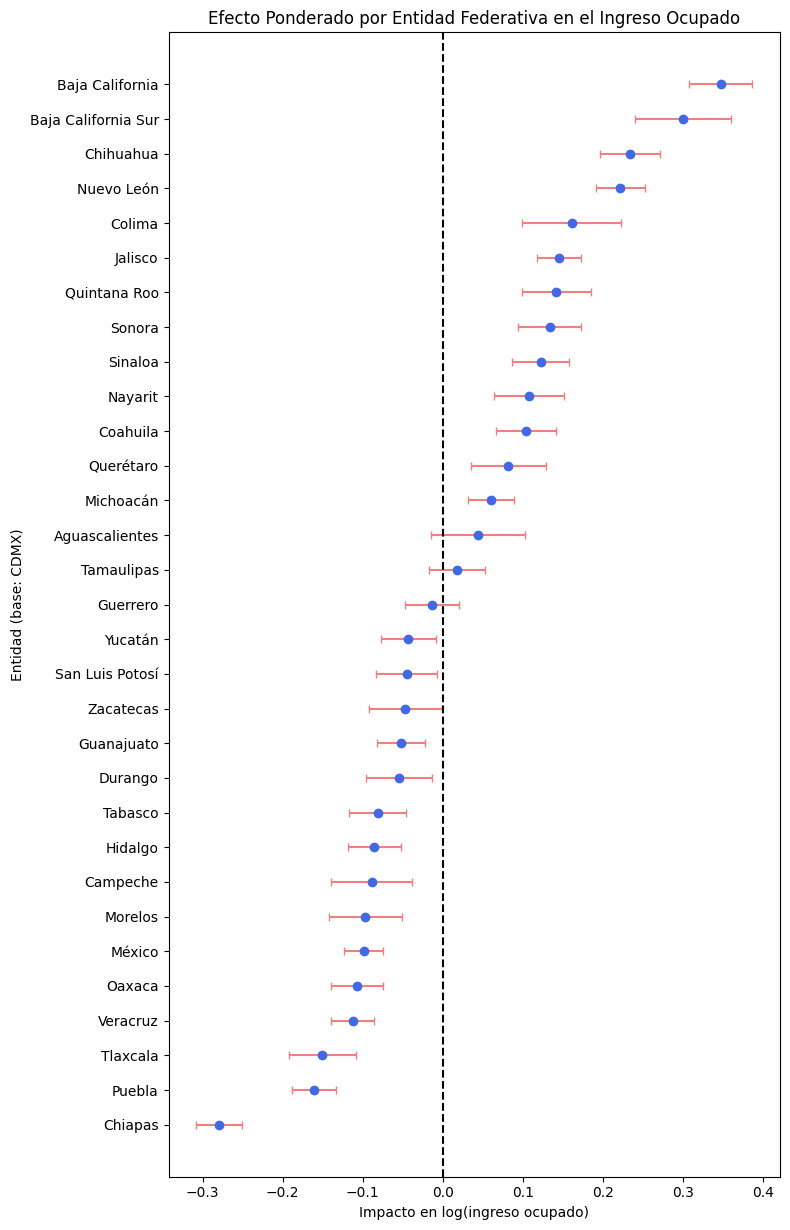

In [31]:
coef_ent = model_pond.params.filter(like='ent_')

# Extraer intervalos de confianza para las mismas variables
conf = model_pond.conf_int().loc[coef_ent.index]
conf.columns = ['Lower CI', 'Upper CI']

# Filtrar valores finitos (evita errores por NaN o inf)
mask = np.isfinite(coef_ent.values) & np.isfinite(conf['Lower CI'].values) & np.isfinite(conf['Upper CI'].values)
coef_ent_valid = coef_ent[mask]
conf_ent_valid = conf.loc[coef_ent_valid.index]

# Crear etiquetas legibles (usando tu diccionario)
etiquetas_ent_valid = [
    entidades.get(int(idx.split('_')[1].split('.')[0]), idx)
    for idx in coef_ent_valid.index
]

# Ordenar los coeficientes (para una gráfica ordenada)
orden = np.argsort(coef_ent_valid.values)
coef_ent_valid = coef_ent_valid.iloc[orden]
conf_ent_valid = conf_ent_valid.iloc[orden]
etiquetas_ent_valid = np.array(etiquetas_ent_valid)[orden]

# Graficar con barras de error
plt.figure(figsize=(8, len(coef_ent_valid) * 0.4))
plt.errorbar(
    coef_ent_valid.values,
    range(len(coef_ent_valid)),
    xerr=[
        coef_ent_valid.values - conf_ent_valid['Lower CI'].values,
        conf_ent_valid['Upper CI'].values - coef_ent_valid.values
    ],
    fmt='o', color='royalblue', ecolor='lightcoral', capsize=3
)
plt.yticks(range(len(coef_ent_valid)), etiquetas_ent_valid)
plt.axvline(0, color='black', linestyle='--')
plt.title('Efecto Ponderado por Entidad Federativa en el Ingreso Ocupado')
plt.xlabel('Impacto en log(ingreso ocupado)')
plt.ylabel('Entidad (base: CDMX)')
plt.tight_layout()
plt.show()

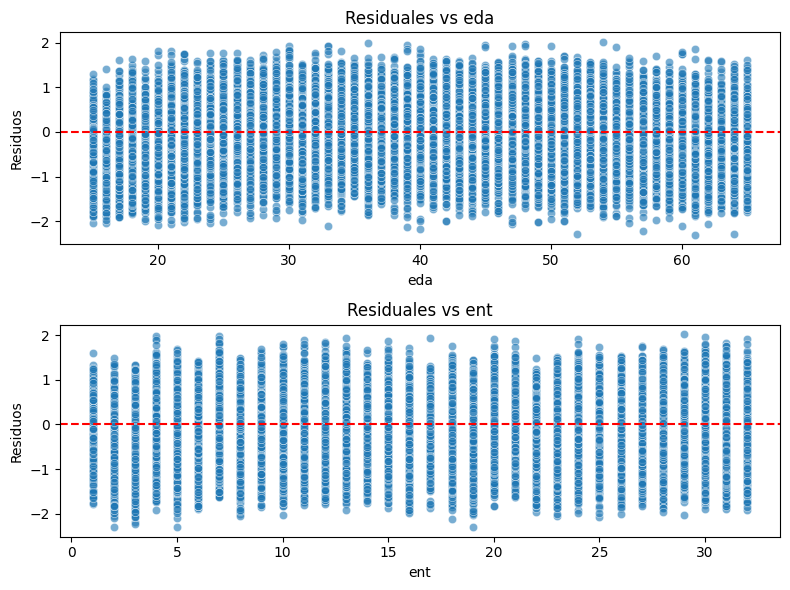

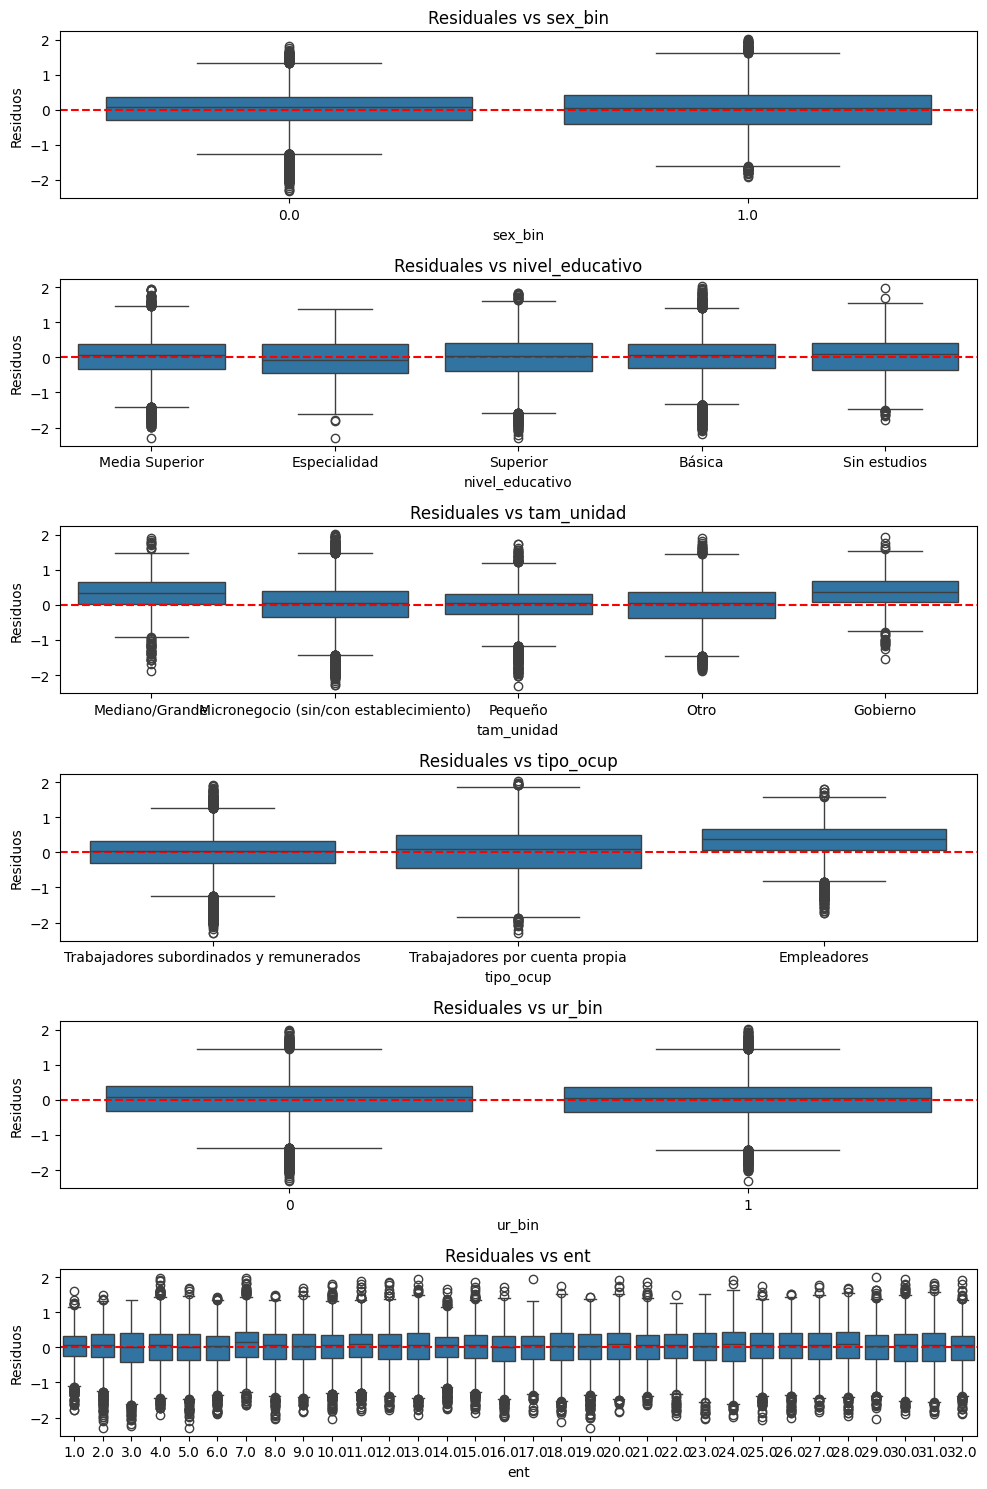

In [32]:
# 1. Variables numéricas
numericas = ['eda', 'ent'] 

df_informal['residuos'] = model_pond.resid
plt.figure(figsize=(8, len(numericas)*3))
for i, var in enumerate(numericas):
    plt.subplot(len(numericas), 1, i+1)
    sns.scatterplot(x=var, y='residuos', data=df_informal, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residuales vs {var}') 
    plt.xlabel(var)
    plt.ylabel('Residuos')
plt.tight_layout()
plt.show()
# 2. Variables categóricas
categoricas = ['sex_bin', 'nivel_educativo', 'tam_unidad', 'tipo_ocup', 'ur_bin', 'ent']  

plt.figure(figsize=(10, len(categoricas)*2.5))
for i, var in enumerate(categoricas):
    plt.subplot(len(categoricas), 1, i+1)
    sns.boxplot(x=var, y='residuos', data=df_informal)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residuales vs {var}')
    plt.xlabel(var)
    plt.ylabel('Residuos')
plt.tight_layout()
plt.show()


### Heterocedasticidad

In [33]:
#Test de Breusch-Pagan (lineal) la varianza del error es la que tiene la relacion lineal
#Ho: Homocedasticidad (la varianza del error es constante)
print('\n --- Test de Breush-Pagan ---')
bp_test = sms.het_breuschpagan(model_pond.resid, model_pond.model.exog)
#Formatear los resultados en una tupla de etiquetas y valores
labels =['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-vaue']
results = list(zip(labels, bp_test))
print('Hipótesis nula (Ho): Homocedasticidad')
for label, value in results:
    print(f'{label}: {value:.4f}')
if bp_test[1] < 0.5:
    print('Resultado: se rechaza la Ho. Hay evidencia de heterocedasticidad')
else:
    print('Resultado: no se rechaza la Ho. No hay evidencia de heterocedasticidad')


 --- Test de Breush-Pagan ---
Hipótesis nula (Ho): Homocedasticidad
LM Statistic: 1721.6988
LM-Test p-value: 0.0000
F-Statistic: 43.1938
F-Test p-vaue: 0.0000
Resultado: se rechaza la Ho. Hay evidencia de heterocedasticidad


In [34]:
#Test de White (no lineal)
#Ho: Homocedasticidad (no hay heterocedasticidad de forma desconocida)
print('\n--- Test de White ---')
white_test = sms.het_white(model_pond.resid, model_pond.model.exog)
#Formatear los resultados
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F=Test p-value']
results = list(zip(labels, white_test))

print('Hipótesis nula (Ho): Homocedasticidad')
for label, value in results:
    print(f'{label}: {value:.4f}')
if white_test[1] < 0.5:
    print('Resultado: se rechaza la Ho. Hay evidencia de heterocedasticidad')
else:
    print('Resultado: no se rechaza la Ho. No hay evidencia de heterocedasticidad')


--- Test de White ---
Hipótesis nula (Ho): Homocedasticidad
LM Statistic: 2747.9901
LM-Test p-value: 0.0000
F-Statistic: 7.3340
F=Test p-value: 0.0000
Resultado: se rechaza la Ho. Hay evidencia de heterocedasticidad


In [47]:
#correcion de White (errores estándates robustos)
print('\n--- Re-estimación del Modelo con Errores Estándar Robustos (White) ---')
#La estimacion de los coeficientes no cambia, solo los errores estándar y, por ende, de los t-trsts, p-values e intervalos de confianza
#El método .fit() puede recubir el tipo de covarianza
modelo_robusto = sm.WLS(y, X).fit(cov_type='HC1')
#Imprimir el resumen del modelo robusto
print(modelo_robusto.summary())


--- Re-estimación del Modelo con Errores Estándar Robustos (White) ---
                            WLS Regression Results                            
Dep. Variable:            log_ingocup   R-squared:                       0.173
Model:                            WLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     306.3
Date:                Thu, 13 Nov 2025   Prob (F-statistic):               0.00
Time:                        07:46:41   Log-Likelihood:                -52590.
No. Observations:               60444   AIC:                         1.053e+05
Df Residuals:                   60402   BIC:                         1.056e+05
Df Model:                          41                                         
Covariance Type:                  HC1                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------

In [56]:
residuos = modelo_robusto.resid  # obtenemos los residuos

# Aplicar prueba Jarque-Bera
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(residuos)

print(f"Estadístico Jarque-Bera: {jb_stat:.4f}")
print(f"p-valor: {jb_pvalue:.4f}")
print(f"Asimetría (skewness): {skew:.4f}")
print(f"Curtosis: {kurtosis:.4f}")

if jb_pvalue < 0.05:
    print("Se rechaza la hipótesis nula: los residuos no son normales")
else:
    print("No se rechaza la hipótesis nula: los residuos pueden considerarse normales")


Estadístico Jarque-Bera: 1854.6999
p-valor: 0.0000
Asimetría (skewness): -0.4068
Curtosis: 3.2729
Se rechaza la hipótesis nula: los residuos no son normales


In [ ]:
# Mostrar todas las variables con VIF mayor a 5, para saber si hay que ajustar otra parte del modelo
pd.set_option('display.max_rows', None)

vif_data_pond[vif_data_pond['VIF'] > 5]

,Variable,VIF
0,const,68.738043


En el modelo ponderado (WLS) estimado para los trabajadores informales se observa que la edad ejerce un efecto positivo y significativo sobre el ingreso (β1 = 0.0040; p < 0.001), sugiriendo que cada año adicional de experiencia laboral se asocia con un aumento cercano al 0.4% en el ingreso.

El sexo muestra una brecha importante en el sector informal: el coeficiente negativo de sex_bin (β = -0.3847; p < 0.001) indica que las mujeres perciben, en promedio, un ingreso 38% menor que los hombres, manteniendo constantes las demás variables.

Asimismo, el ámbito rural (ur_bin) tiene un efecto negativo y significativo (β = -0.1091; p < 0.001), reflejando que los trabajadores rurales ganan alrededor de 10% menos que sus contrapartes urbanas.

En cuanto al nivel educativo, los coeficientes muestran una relación positiva entre educación y salario. Destacan los efectos de educación superior (β = 0.1689; p < 0.001) y especialidad (β = 0.4684; p < 0.001), lo que implica que los trabajadores con estudios profesionales o técnicos especializados perciben entre 17% y 47% más ingreso, respectivamente, que quienes solo tienen educación básica. Por el contrario, no contar con estudios reduce los ingresos en aproximadamente 14%.

Respecto a la entidad, Chiapas es el estado que más afecta negativamente el ingreso, constituyendo una reducción aproximada al 30%, seguido de Puebla (~20%) y Tlaxcala (~18%). Mientras que los estados que contribuyen al aumento salarial en trabajadores informales están Baja California (~40%), Baja California Sur (~30%) y Chihuahua (~30%).

Finalmente, el tamaño de la unidad económica también influye de forma significativa: laborar en micronegocios se asocia con un aumento de 15% en el ingreso respecto a las unidades más pequeñas o no establecidas. Esto puede explicarse por la concentración de trabajadores con mayor autonomía o estabilidad relativa dentro de este subsegmento del trabajo informal.

# Formales

In [36]:
X_formal = df_formal[['eda', 'sex_bin', 'nivel_educativo', 'tam_unidad', 'tipo_ocup', 'ur_bin', 'ent']]
y_formal = df_formal['log_ingocup']

# Convertimos variables categóricas a dummies (automático)
X_formal = pd.get_dummies(X_formal, columns=['nivel_educativo', 'tam_unidad', 'tipo_ocup'], drop_first=True)
X_formal = pd.concat([X_formal, dummies_ent], axis=1)
X_formal = X_formal.apply(pd.to_numeric, errors='coerce')
X_formal = X_formal.dropna()
y_formal = y_formal.loc[X_formal.index]
# Agregamos la constante (intercepto)
X_formal = sm.add_constant(X_formal)

# Ajustamos el modelo OLS
model_formal = sm.OLS(y_formal, X_formal).fit()

# Resumen del modelo
print(model_formal.summary())

                            OLS Regression Results                            
Dep. Variable:            log_ingocup   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     377.1
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:48:58   Log-Likelihood:                -27546.
No. Observations:               59131   AIC:                         5.518e+04
Df Residuals:                   59086   BIC:                         5.559e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [37]:
model_formal = sm.WLS(y_formal, X_formal, weights=df_formal['fac_tri']).fit()
print(model_formal.summary())

                            WLS Regression Results                            
Dep. Variable:            log_ingocup   R-squared:                       0.233
Model:                            WLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     407.7
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:48:58   Log-Likelihood:                -41529.
No. Observations:               59131   AIC:                         8.315e+04
Df Residuals:                   59086   BIC:                         8.355e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [38]:
# Extraer tabla con coeficientes, errores, p-valores, etc.
tabla = model_formal.summary2().tables[1]

# Filtrar solo las variables que empiezan con 'ent'
ent_tabla = tabla[tabla.index.str.startswith('ent')]

# Ordenar de menor a mayor coeficiente
ent_tabla_ordenada = ent_tabla.sort_values(by='Coef.', ascending=True)

# Mostrar los 5 más bajos y los 5 más altos
print("5 entidades con menor coeficiente:")
print(ent_tabla_ordenada.head(5))
print("\n5 entidades con mayor coeficiente:")
print(ent_tabla_ordenada.tail(5))

5 entidades con menor coeficiente:
             Coef.  Std.Err.          t          P>|t|    [0.025    0.975]
ent_29.0 -0.514444  0.016013 -32.127458  1.584706e-224 -0.545828 -0.483059
ent_32.0 -0.417320  0.013884 -30.058029  5.276435e-197 -0.444533 -0.390108
ent_31.0 -0.378092  0.010076 -37.524891  1.413261e-304 -0.397840 -0.358343
ent_30.0 -0.371913  0.007821 -47.552570   0.000000e+00 -0.387242 -0.356584
ent_27.0 -0.360771  0.012108 -29.796865  1.174398e-193 -0.384502 -0.337040

5 entidades con mayor coeficiente:
            Coef.  Std.Err.          t          P>|t|    [0.025    0.975]
ent_5.0  0.062908  0.010417   6.038964   1.560296e-09  0.042491  0.083326
ent_8.0  0.065394  0.009645   6.780404   1.209625e-11  0.046491  0.084298
ent_6.0  0.091074  0.019709   4.620992   3.827142e-06  0.052445  0.129704
ent_3.0  0.238384  0.015539  15.341256   5.130162e-53  0.207928  0.268840
ent_2.0  0.287479  0.011556  24.877012  6.631575e-136  0.264829  0.310129


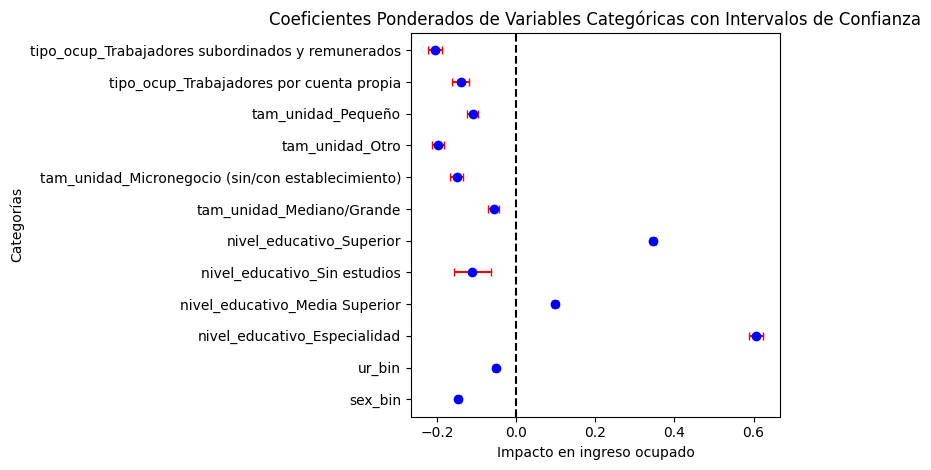

In [ ]:
# Coeficientes e intervalos de confianza del modelo formal ponderado
coef_formal_pond = model_formal.params
conf_formal_pond = model_formal.conf_int()
conf_formal_pond.columns = ['Lower CI', 'Upper CI']

# Filtramos solo variables categóricas
coef_f_categ_p = coef_formal_pond[1:].filter(regex='|'.join(categoricas2))
conf_f_categ_p = conf_formal_pond.loc[coef_f_categ_p.index]

# 7Gráfico de coeficientes con intervalos de confianza
plt.figure(figsize=(8, len(coef_f_categ_p) * 0.4))
plt.errorbar(
    coef_f_categ_p.values,
    range(len(coef_f_categ_p)),
    xerr=[
        coef_f_categ_p.values - conf_f_categ_p['Lower CI'].values,
        conf_f_categ_p['Upper CI'].values - coef_f_categ_p.values
    ],
    fmt='o',
    color='blue',
    ecolor='red',
    capsize=3
)
plt.yticks(range(len(coef_f_categ_p)), coef_f_categ_p.index)
plt.axvline(x=0, color='black', linestyle='--')
plt.title('Coeficientes Ponderados de Variables Categóricas con Intervalos de Confianza')
plt.xlabel('Impacto en ingreso ocupado')
plt.ylabel('Categorías')
plt.tight_layout()
plt.show()


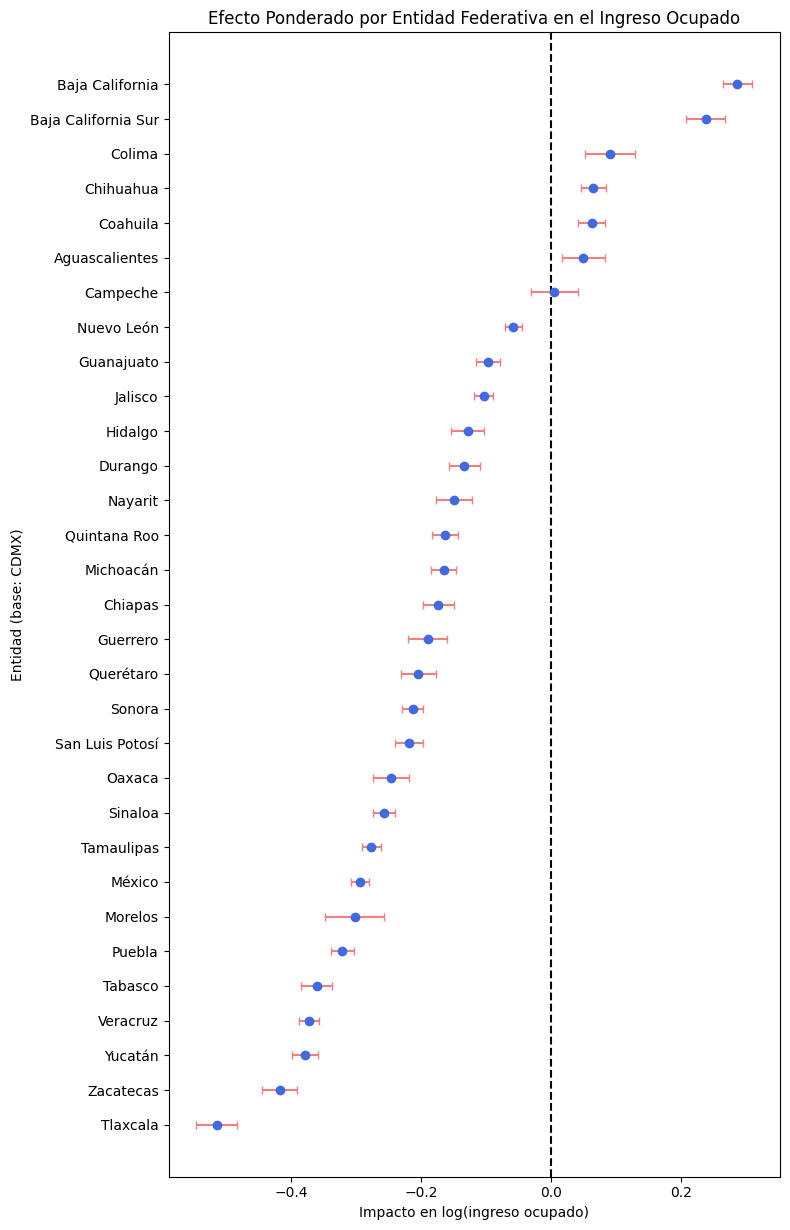

In [40]:
coef_ent = model_formal.params.filter(like='ent_')

# Extraer intervalos de confianza para las mismas variables
conf = model_formal.conf_int().loc[coef_ent.index]
conf.columns = ['Lower CI', 'Upper CI']

# Filtrar valores finitos (evita errores por NaN o inf)
mask = np.isfinite(coef_ent.values) & np.isfinite(conf['Lower CI'].values) & np.isfinite(conf['Upper CI'].values)
coef_ent_valid = coef_ent[mask]
conf_ent_valid = conf.loc[coef_ent_valid.index]

# Crear etiquetas legibles (usando tu diccionario)
etiquetas_ent_valid = [
    entidades.get(int(idx.split('_')[1].split('.')[0]), idx)
    for idx in coef_ent_valid.index
]

# Ordenar los coeficientes (para una gráfica ordenada)
orden = np.argsort(coef_ent_valid.values)
coef_ent_valid = coef_ent_valid.iloc[orden]
conf_ent_valid = conf_ent_valid.iloc[orden]
etiquetas_ent_valid = np.array(etiquetas_ent_valid)[orden]

# Graficar con barras de error
plt.figure(figsize=(8, len(coef_ent_valid) * 0.4))
plt.errorbar(
    coef_ent_valid.values,
    range(len(coef_ent_valid)),
    xerr=[
        coef_ent_valid.values - conf_ent_valid['Lower CI'].values,
        conf_ent_valid['Upper CI'].values - coef_ent_valid.values
    ],
    fmt='o', color='royalblue', ecolor='lightcoral', capsize=3
)
plt.yticks(range(len(coef_ent_valid)), etiquetas_ent_valid)
plt.axvline(0, color='black', linestyle='--')
plt.title('Efecto Ponderado por Entidad Federativa en el Ingreso Ocupado')
plt.xlabel('Impacto en log(ingreso ocupado)')
plt.ylabel('Entidad (base: CDMX)')
plt.tight_layout()
plt.show()

In [41]:
vif_formal_data_pond = pd.DataFrame()
vif_formal_data_pond["Variable"] = X_formal.columns
vif_formal_data_pond["VIF"] = [variance_inflation_factor(X_formal.values, i) for i in range(X_formal.shape[1])]
print(vif_formal_data_pond)

c:\Users\ASTRID\Documents\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\ASTRID\Documents\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                                             Variable       VIF
0                                               const  0.000000
1                                                 eda  1.088914
2                                             sex_bin  1.029130
3                                              ur_bin  1.070239
4                                                 ent       inf
5                        nivel_educativo_Especialidad  1.119709
6                      nivel_educativo_Media Superior  1.442148
7                        nivel_educativo_Sin estudios  1.015992
8                            nivel_educativo_Superior  1.539336
9                           tam_unidad_Mediano/Grande  4.067862
10  tam_unidad_Micronegocio (sin/con establecimiento)  3.331013
11                                    tam_unidad_Otro  2.263051
12                                 tam_unidad_Pequeño  3.341922
13           tipo_ocup_Trabajadores por cuenta propia  2.268775
14  tipo_ocup_Trabajadores subordinados 

En los informales, los VIF altos (6–18) indicaban que había solapamiento fuerte entre variables, especialmente entre tipo de ocupación y tamaño de unidad económica.
Eso puede reflejar cómo, en la realidad, las personas en la informalidad suelen concentrarse en ciertos tipos de unidades económicas, haciendo difícil aislar el efecto de cada variable.

En cambio, en los formales, las relaciones son más diferenciadas:
el tamaño del establecimiento, el tipo de ocupación y la educación no se solapan tanto, lo que sugiere estructuras laborales más definidas y separadas.

In [ ]:
#Test de Breusch-Pagan (lineal) la varianza del error es la que tiene la relacion lineal
#Ho: Homocedasticidad (la varianza del error es constante)
print('\n --- Test de Breush-Pagan ---')
bp_test = sms.het_breuschpagan(model_formal.resid, model_formal.model.exog)
#Formatear los resultados en una tupla de etiquetas y valores
labels =['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-vaue']
results = list(zip(labels, bp_test))
print('Hipótesis nula (Ho): Homocedasticidad')
for label, value in results:
    print(f'{label}: {value:.4f}')
if bp_test[1] < 0.5:
    print('Resultado: se rechaza la Ho. Hay evidencia de heterocedasticidad')
else:
    print('Resultado: no se rechaza la Ho. No hay evidencia de heterocedasticidad')


 --- Test de Breush-Pagan ---
Hipótesis nula (Ho): Homocedasticidad
LM Statistic: 2981.6392
LM-Test p-value: 0.0000
F-Statistic: 224.6955
F-Test p-vaue: 0.0000
Resultado: se rechaza la Ho. Hay evidencia de heterocedasticidad


In [ ]:
#Test de White (no lineal)
#Ho: Homocedasticidad (no hay heterocedasticidad de forma desconocida)
print('\n--- Test de White ---')
white_test = sms.het_white(model_formal.resid, model_formal.model.exog)
#Formatear los resultados
labels = ['LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F=Test p-value']
results = list(zip(labels, white_test))

print('Hipótesis nula (Ho): Homocedasticidad')
for label, value in results:
    print(f'{label}: {value:.4f}')
if white_test[1] < 0.5:
    print('Resultado: se rechaza la Ho. Hay evidencia de heterocedasticidad')
else:
    print('Resultado: no se rechaza la Ho. No hay evidencia de heterocedasticidad')


--- Test de White ---
Hipótesis nula (Ho): Homocedasticidad
LM Statistic: 3456.1720
LM-Test p-value: 0.0000
F-Statistic: 40.3713
F=Test p-value: 0.0000
Resultado: se rechaza la Ho. Hay evidencia de heterocedasticidad


In [43]:
#correcion de White (errores estándates robustos)
print('\n--- Re-estimación del Modelo con Errores Estándar Robustos (White) ---')
#La estimacion de los coeficientes no cambia, solo los errores estándar y, por ende, de los t-trsts, p-values e intervalos de confianza
#El método .fit() puede recubir el tipo de covarianza
modelo_robusto_formal = sm.WLS(y_formal, X_formal).fit(cov_type='HC1')
#Imprimir el resumen del modelo robusto
print(modelo_robusto_formal.summary())


--- Re-estimación del Modelo con Errores Estándar Robustos (White) ---
                            WLS Regression Results                            
Dep. Variable:            log_ingocup   R-squared:                       0.219
Model:                            WLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                 8.418e+05
Date:                Wed, 12 Nov 2025   Prob (F-statistic):               0.00
Time:                        20:49:18   Log-Likelihood:                -27546.
No. Observations:               59131   AIC:                         5.518e+04
Df Residuals:                   59086   BIC:                         5.559e+04
Df Model:                          44                                         
Covariance Type:                  HC1                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------

In [49]:
coef_ent = model_formal.params.filter(like='ent_')
print(coef_ent)

ent_1.0     0.050230
ent_2.0     0.287479
ent_3.0     0.238384
ent_4.0     0.005510
ent_5.0     0.062908
ent_6.0     0.091074
ent_7.0    -0.173021
ent_8.0     0.065394
ent_10.0   -0.133078
ent_11.0   -0.096835
ent_12.0   -0.189848
ent_13.0   -0.127923
ent_14.0   -0.103561
ent_15.0   -0.294039
ent_16.0   -0.165202
ent_17.0   -0.301989
ent_18.0   -0.149167
ent_19.0   -0.057813
ent_20.0   -0.246083
ent_21.0   -0.321328
ent_22.0   -0.204042
ent_23.0   -0.162532
ent_24.0   -0.218091
ent_25.0   -0.257312
ent_26.0   -0.212410
ent_27.0   -0.360771
ent_28.0   -0.276469
ent_29.0   -0.514444
ent_30.0   -0.371913
ent_31.0   -0.378092
ent_32.0   -0.417320
dtype: float64


In [51]:
coef_ent = model_pond.params.filter(like='ent_')
print(coef_ent)

ent_1.0     0.043683
ent_2.0     0.347195
ent_3.0     0.299868
ent_4.0    -0.088944
ent_5.0     0.103841
ent_6.0     0.160744
ent_7.0    -0.279168
ent_8.0     0.233487
ent_10.0   -0.054310
ent_11.0   -0.052302
ent_12.0   -0.013773
ent_13.0   -0.085966
ent_14.0    0.145231
ent_15.0   -0.099028
ent_16.0    0.060282
ent_17.0   -0.096659
ent_18.0    0.107575
ent_19.0    0.221850
ent_20.0   -0.107752
ent_21.0   -0.161175
ent_22.0    0.081841
ent_23.0    0.141793
ent_24.0   -0.045210
ent_25.0    0.122392
ent_26.0    0.133387
ent_27.0   -0.081441
ent_28.0    0.018038
ent_29.0   -0.150664
ent_30.0   -0.112598
ent_31.0   -0.043103
ent_32.0   -0.046676
dtype: float64


En el caso de los trabajadores formales, la edad mantiene un efecto positivo (β = 0.0041; p < 0.001), de magnitud similar al observado en el sector informal, lo que sugiere retornos relativamente constantes a la experiencia laboral.

La brecha de género persiste aunque es menor (β = -0.1559; p < 0.001), lo que implica que las mujeres formales ganan en promedio un 15% menos que los hombres. El ámbito rural también presenta un efecto negativo (β = -0.0448; p < 0.001), equivalente a una pérdida salarial aproximada de 4%, lo cual es menor respecto a los trabajadores informales, pero evidencia que incluso con acceso a empleos formales, no se eliminan por completo las diferencias salariales territoriales.

El nivel educativo se confirma como el principal determinante del ingreso formal. Los trabajadores con educación superior o especialidad perciben respectivamente 33% y 57% más que aquellos con educación básica, mientras que quienes carecen de estudios presentan un ingreso 13% menor.

A diferencia del modelo informal, la variable de entidad federativa (β = 0.0143; p < 0.001) resultó significativa y positiva, sugiriendo la existencia de efectos regionales importantes: los estados con mayor desarrollo económico concentran ingresos laborales más altos, lo cual refleja una segmentación territorial en los retornos a la formalidad. Los estados que afectan negativamente a los ingresos son Tlaxcala (~60%), Zacatecas (~40%) y Yucatán (~39%); mientras que los estados que tienen un impacto positivo respecto al ingreso son Baja California (~30%), Baja California Sur (~20%) y Colima (~10%).

## Implementar modelo de Machine Learning

In [95]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

In [97]:
# Crear versiones equivalentes en sklearn
modelo_informal_sklearn = LinearRegression()
modelo_formal_sklearn = LinearRegression()

# Configurar K-Fold
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

# Diccionario de modelos
modelos_datos = {
    "Informales": (modelo_informal_sklearn, X, y),
    "Formales": (modelo_formal_sklearn, X_formal, y_formal)
}

# Validación cruzada
results = {}
for name, (model, X_data, y_data) in modelos_datos.items():
    scores = cross_val_score(model, X_data, y_data, cv=kfold, scoring='r2', n_jobs=-1)
    results[name] = (np.mean(scores), np.std(scores))

# Mostrar resultados
for name, (mean_r2, std_r2) in results.items():
    print(f"{name}: R² medio = {mean_r2:.4f} ± {std_r2:.4f}")


Informales: R² medio = 0.1717 ± 0.0035
Formales: R² medio = 0.2179 ± 0.0059


Los resultados del ejercicio de validación cruzada K-Fold (3 particiones) muestran que el modelo de ingresos del sector formal obtiene un coeficiente de determinación promedio de 0.2179, ligeramente superior al del sector informal (0.1717).

Esto indica que los determinantes observables (edad, educación, género, y ubicación geográfica) explican con mayor precisión la variabilidad salarial en la formalidad, donde las estructuras salariales tienden a ser más estables y reguladas.

En contraste, el menor poder explicativo del modelo informal sugiere una mayor dispersión de los ingresos, probablemente asociada a la heterogeneidad del autoempleo, la falta de regulación y la dependencia de factores contextuales no observados.

Ambos modelos mantienen una baja desviación estándar, lo que refleja estabilidad estadística y consistencia entre las distintas divisiones de la muestra.

In [ ]:
# Modelo de ML
# Conjunto informal, aparecen errores después, por eso le puse que sean copias
X_inf = X.copy()
y_inf = y.copy()

# Conjunto formal
X_for = X_formal.copy()
y_for = y_formal.copy()

# Modelos a usar
models = {
    "Lineal": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
}

#Validación cruzada 
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

def evaluar_modelos(X, y):
    resultados = {}
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=kfold, scoring='r2', n_jobs=-1)
        resultados[name] = (np.mean(scores), np.std(scores))
    return resultados

#Evaluacion
resultados_informal = evaluar_modelos(X_inf, y_inf)
resultados_formal = evaluar_modelos(X_for, y_for)
print("=== Resultados: Trabajadores Informales ===")
for name, (mean_r2, std_r2) in resultados_informal.items():
    print(f"{name}: R² medio = {mean_r2:.4f} ± {std_r2:.4f}")
print("\n=== Resultados: Trabajadores Formales ===")
for name, (mean_r2, std_r2) in resultados_formal.items():
    print(f"{name}: R² medio = {mean_r2:.4f} ± {std_r2:.4f}")

=== Resultados: Trabajadores Informales ===
Lineal: R² medio = 0.1717 ± 0.0035
Random Forest: R² medio = 0.0459 ± 0.0064
Gradient Boosting: R² medio = 0.2244 ± 0.0049

=== Resultados: Trabajadores Formales ===
Lineal: R² medio = 0.2179 ± 0.0059
Random Forest: R² medio = 0.0670 ± 0.0041
Gradient Boosting: R² medio = 0.2356 ± 0.0043


El modelo de Gradient Boosting presenta el mejor ajuste en ambos grupos, lo que sugiere que existen patrones no lineales en la relación entre los determinantes (educación, edad, jornada, sector, etc.) y el ingreso.
Sin embargo, la mejora respecto al modelo lineal es moderada, lo que indica que los determinantes estructurales del ingreso siguen teniendo un comportamiento principalmente lineal.

# Conclusiones

El análisis econométrico de los determinantes del ingreso en el mercado laboral mexicano evidencia que la informalidad no es una condición pasajera, sino una estructura persistente de desigualdad que limita los ingresos y amplifica brechas preexistentes por género, educación y territorio.

En promedio, los trabajadores formales perciben alrededor de 11,158 pesos mensuales, frente a 6,185 pesos en el sector informal, lo que refleja una brecha salarial del 44 %. Aun con edades y características similares, los informales enfrentan retornos menores al capital humano, especialmente cuando presentan bajo nivel educativo, condición de mujer o residencia rural.

La educación superior y técnica sigue siendo el factor más determinante del ingreso en ambos sectores, aunque su efecto es más limitado en la informalidad. En cuanto al género, las mujeres informales ganan cerca de 40 % menos que los hombres, mientras que en la formalidad la brecha se reduce a 15 %, confirmando el papel amortiguador del empleo formal.

Las diferencias regionales son notables: los estados del norte (como Baja California y Chihuahua) concentran los salarios más altos, mientras que el sur (Chiapas, Tlaxcala) presenta los más bajos, lo que resalta la dimensión territorial de la desigualdad laboral.

Finalmente, los modelos de aprendizaje automático (Gradient Boosting) mejoraron ligeramente la capacidad predictiva frente al modelo lineal, lo que sugiere que los determinantes del ingreso presentan patrones moderadamente no lineales, aunque la relación general se mantiene esencialmente estructural.

En conjunto, los resultados confirman que la informalidad refleja y reproduce las desigualdades estructurales del país y que su reducción requiere políticas coordinadas que impulsen tanto la formalización del empleo como el acceso equitativo a la educación y a oportunidades laborales de calidad.

# Recomendaciones

1. Ampliar las variables explicativas incorporarando factores como experiencia laboral, sector económico y extensión de la jornada podría mejorar la capacidad predictiva del modelo y captar mejor las diferencias estructurales.

2. Incluir interacciones y efectos no lineales, dado que el Gradient Boosting tuvo mejor desempeño, esto solo como medida adicional ya que la mejora es moderada.

3. Profundizar en la dimensión regional, considerando modelos separados por regiones (norte, centro, sur) debido a la diferencia del salario mínimo, o incluir variables macroeconómicas estatales (PIB per cápita, informalidad estatal, nivel educativo promedio) para capturar mejor la heterogeneidad territorial.

4. Validación y comparación de modelos aplicando validaciones cruzadas más robustas, ya que el rendimiento de la computadora donde se realizó este proyecto no lo permitió.

5. Análisis de brecha salarial por género, profundizando en un submodelo centrado en la desigualdad de género dentro de la informalidad podría dar lugar a un estudio complementario de alto valor analítico y social.

Bibliografía.

BBVA. (2025). ¿Qué es una microempresa y cuáles son sus objetivos? bbva.com . https://www.bbva.mx/educacion-financiera/creditos/credito-pyme-que-es-una-microempresa.html
Castro y Bracamontes, M. C. (2020, julio). La informalidad laboral en las entidades de México en el siglo XXI: posibles factores explicativos. Org.mx. https://rde.inegi.org.mx/index.php/2021/04/08/la-informalidad-laboral-en-las-entidades-de-mexico-en-el-siglo-xxi-posibles-factores-explicativos/
Comisión Nacional del Sistema de Ahorro para el Retiro. (2025, marzo). Pensión por Régimen 97. gob.mx. Recuperado el 30 de mayo de 2025, de https://www.gob.mx/consar/articulos/por-regimen-de-97
CONEVAL. (2022). Estudios sobre el mercado laboral y la pobreza en México. Consejo Nacional de Evaluación de la Política de Desarrollo Social. https://www.coneval.org.mx
INEGI (2023). Encuesta Nacional de Ocupación y Empleo (ENOE). Comunicado de prensa y tabulados. https://www.inegi.org.mx/programas/enoe
INEGI. (2023, diciembre). MEDICIÓN DE LA ECONOMÍA INFORMAL (MEI). inegi.org.mx. https://www.inegi.org.mx/contenidos/saladeprensa/boletines/2023/MDEI/MDEI2022.pdf
México, ¿cómo vamos? (s/f). Informalidad laboral. Recuperado el 13 de mayo de 2025, de https://mexicocomovamos.mx/semaforo-nacional/informalidad-laboral/
OIT. (2013). FORLAC (Oficina Regional para América Latina y el Caribe, Ed.). ilo.org. https://www.ilo.org/es/media/453181/download
OIT. (2021). La economía informal en América Latina y el Caribe: recomendaciones para su formalización. Oficina Regional para América Latina y el Caribe. https://www.ilo.org
OIT. (2021, septiembre). Teoría del cambio: Formalización empresarial para el trabajo decente. Ilo.org. https://www.ilo.org/es/media/7851/download
Rodríguez, E. C., de la Torre Ruiz, H. A., & Dávila, S. O. R. (Eds.). (2016). Características y determinantes de la informalidad laboral en México. Estudios regionales en economía, población y desarrollo. (Núm. 35). Universidad Autónoma de Ciudad Juárez.